In [3]:
import scanpy as sc 
import anndata as ad

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:

thymus_raw = ad.read_h5ad("/Users/marikaclark/thymus-vae-tabula-sapiens/data/raw/Thymus_TSP1_30_version2d_10X_smartseq_scvi_Nov122024.h5ad")

# Quality Control

#### Checking for presence of mitochondrial and ribosomal genes 

In [5]:
np.sum(thymus_raw.var_names.str.startswith("MT") == True)
np.sum(thymus_raw.var_names.str.startswith(("RPS", "RPL")) == True)


1475

In [6]:
thymus_raw.var["mt"] = thymus_raw.var_names.str.startswith("MT")
thymus_raw.var["ribo"] = thymus_raw.var_names.str.startswith("RPS", "RPL")

In [7]:
sc.pp.calculate_qc_metrics(thymus_raw, qc_vars = ["mt", "ribo"])

(                                                 n_genes_by_counts  \
 TSP14_Thymus_NA_SS2_B134098_D102004_Immune_E19                4986   
 TSP14_Thymus_NA_SS2_B134098_D102004_Immune_G21                5364   
 TSP14_Thymus_NA_SS2_B134098_D102004_Immune_D16                3904   
 TSP14_Thymus_NA_SS2_B134098_D102004_Immune_F18                2176   
 TSP14_Thymus_NA_SS2_B134098_D102004_Immune_L22                3227   
 ...                                                            ...   
 TSP21_Thymus_NA_10X_1_1_5prime_TTTGTCAAGGTGGGTT               1673   
 TSP21_Thymus_NA_10X_1_1_5prime_TTTGTCAAGTGACATA               1851   
 TSP21_Thymus_NA_10X_1_1_5prime_TTTGTCACAATGAATG               1524   
 TSP21_Thymus_NA_10X_1_1_5prime_TTTGTCACACACGCTG               2450   
 TSP21_Thymus_NA_10X_1_1_5prime_TTTGTCATCTGCGACG               2050   
 
                                                  log1p_n_genes_by_counts  \
 TSP14_Thymus_NA_SS2_B134098_D102004_Immune_E19                  8.51

In [29]:
thymus_raw

AnnData object with n_obs × n_vars = 42729 × 61806
    obs: 'donor', 'tissue', 'anatomical_position', 'method', 'cdna_plate', 'library_plate', 'notes', 'cdna_well', 'old_index', 'assay', 'sample_id', 'replicate', '10X_run', '10X_barcode', 'ambient_removal', 'donor_method', 'donor_assay', 'donor_tissue', 'donor_tissue_assay', 'cell_ontology_class', 'cell_ontology_id', 'compartment', 'broad_cell_class', 'free_annotation', 'manually_annotated', 'published_2022', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ercc', 'pct_counts_ercc', '_scvi_batch', '_scvi_labels', 'scvi_leiden_donorassay_full', 'age', 'sex', 'ethnicity', 'scvi_leiden_res05_tissue', 'sample_number'
    var: 'ensembl_id', 'gene_symbol', 'genome', 'mt', 'ercc', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std', 'ribo'
    uns: '_scvi_manager_uuid', '_scvi_uuid', '_training_mode', 'age_colors', 'assay_colors', 'compartment_colors', 'donor_colors'

In [8]:
def qc_pca_plot_fast(adata):
    """
    Quick QC PCA without transposing.
    Panels:
      TL:  Gene QC scatter — mean_counts vs pct_dropout_by_counts (from .var)
      TR:  PCA (cells) colored by pct_counts_mt
      BL:  PCA (cells) colored by donor
      BR:  PCA (cells) colored by replicate
    """
    # --- make a lightweight working copy of cells x genes ---
    X = adata.copy()

    # highly variable genes -> speeds PCA massively
    sc.pp.highly_variable_genes(X, n_top_genes=n_top_genes, flavor="seurat_v3")
    X = X[:, X.var["highly_variable"]].copy()

    # scale & PCA on cells (no transpose)
    sc.pp.scale(X)
    sc.pp.pca(X)

    # figure
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))

    # TL: gene-level QC (no transpose; plot directly from .var)
    v = adata.var  # original var so we keep all genes
    axs[0, 0].scatter(
        v["mean_counts"], v["pct_dropout_by_counts"], s=4, alpha=0.5
    )
    axs[0, 0].set_xlabel("Gene mean counts")
    axs[0, 0].set_ylabel("% dropout by counts")
    axs[0, 0].set_title("Gene QC: mean vs dropout")

    # TR: mito %
    sc.pl.pca(X, color="pct_counts_mt", ax=axs[0, 1], show=False)
    axs[0, 1].set_title("Cell PCA • % mito counts")

    # BL: donor
    if "donor" in X.obs:
        sc.pl.pca(X, color="donor", ax=axs[1, 0], show=False)
        axs[1, 0].set_title("Cell PCA • donor")
    else:
        axs[1, 0].axis("off")

    # BR: replicate
    if "replicate" in X.obs:
        sc.pl.pca(X, color="replicate", ax=axs[1, 1], show=False)
        axs[1, 1].set_title("Cell PCA • replicate")
    else:
        axs[1, 1].axis("off")

    plt.tight_layout()
    return fig


In [23]:

def qc_pca_quick(adata):

    sc.pl.scatter(adata, basis="pca", color="pct_counts_mt", show=False, title = "% mito counts")

    sc.pl.scatter(adata, basis="pca", color="donor", show=False, title = "donor")

    sc.pl.scatter(adata, basis="pca", color="replicate",  show=False, title = "replicate")

    sc.pl.scatter(adata, basis="pca", color="n_genes_by_counts", show=False, title = "# genes by counts")

    plt.show()
    return None


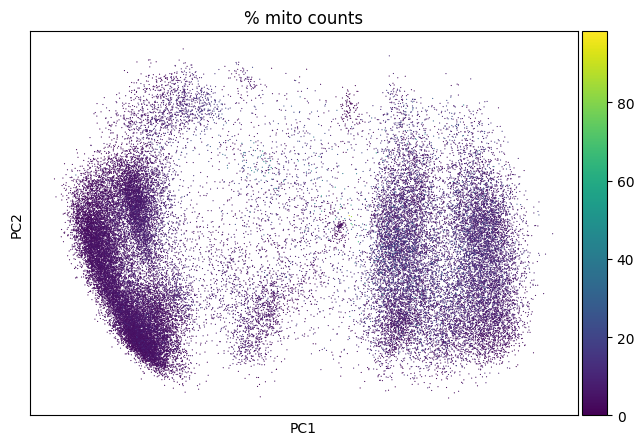

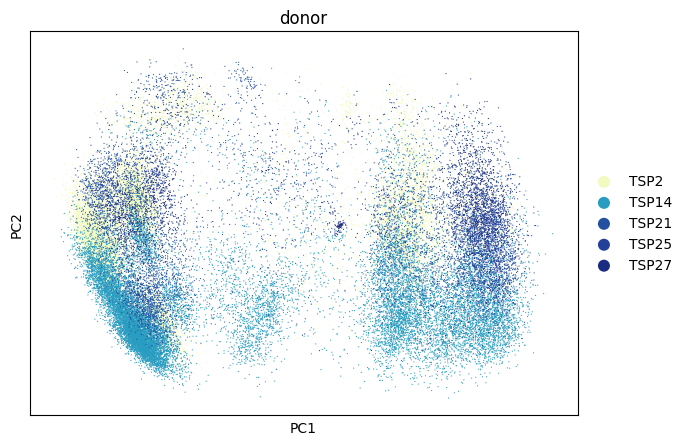

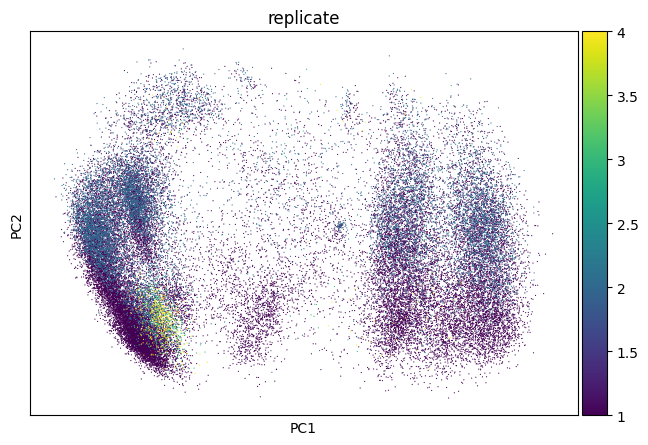

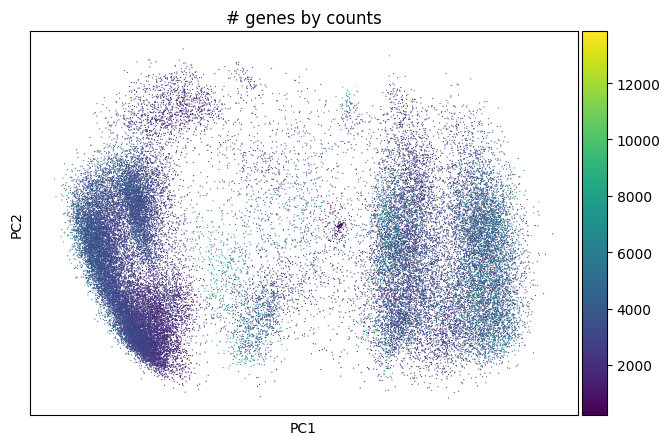

In [24]:
qc_pca_quick(thymus_raw)

In [10]:
import scipy.sparse as sp
print("adata shape:", thymus_raw.shape)
print("X is sparse:", sp.issparse(thymus_raw.X))

# Did HVG filtering actually reduce features?
X = thymus_raw.copy()
sc.pp.highly_variable_genes(X, n_top_genes=3000, flavor="seurat_v3")
print("HVG kept:", X.var["highly_variable"].sum())  # should be ~3000


adata shape: (42729, 61806)
X is sparse: True


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


HVG kept: 3000
